Importerer biblioteker og definerer variabler

In [131]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import streamlit as st
from GHEtool import Borefield, FluidData, GroundData, PipeData
import pygfunction as gt

dekgrad = 0.90
virkgrad = 0.80  #Virkningsgrad til kompressor i varmepumpen
startCOP = 5 #Startgjett for COP-verdi for hver time gjennom (hvert) år(et).

In [132]:
utetemp_for_maks_turtemp = -10
utetemp_for_min_turtemp = 0
maks_turtemp = 45
min_turtemp = 35

Funksjonsuttrykket blir y= [0.08451848] x + [4.17957685]
Funksjonsuttrykket blir y= [0.06379808] x + [3.45767628]


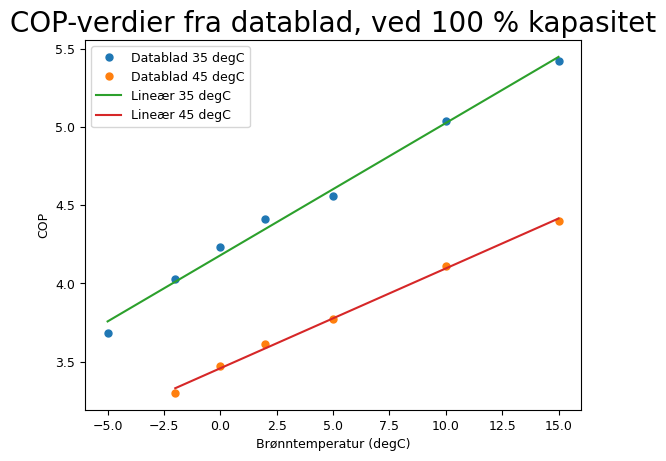

In [133]:
# COP-Verdier fra datablad
databladtemp35 = np.array([-5,-2,0,2,5,10,15])
COP_data35 = np.array([3.68, 4.03, 4.23, 4.41, 4.56, 5.04, 5.42])
databladtemp45 = np.array([-2,0,2,5,10,15])
COP_data45 = np.array([3.3, 3.47, 3.61, 3.77, 4.11, 4.4])

#Kjører lineær regresjon på COP-verdier fra datablad:
from lin_reg import *
lin_COP_data35 = lin_reg(databladtemp35,COP_data35)
lin_COP_data45 = lin_reg(databladtemp45,COP_data45)

# Plotter COP-verdier fra datablad
plt.plot(databladtemp35,COP_data35,'o')
plt.plot(databladtemp45,COP_data45,'o')
plt.plot(databladtemp35,lin_COP_data35)
plt.plot(databladtemp45,lin_COP_data45)
plt.legend(['Datablad 35 degC', 'Datablad 45 degC','Lineær 35 degC','Lineær 45 degC'])
plt.xlabel('Brønntemperatur (degC)')
plt.ylabel('COP')
plt.title('COP-verdier fra datablad, ved 100 % kapasitet', fontsize = 20)
plt.show()

# Parametre i uttrykket for den lineære regresjonen av COP fra datablad
stigtall35 = (lin_COP_data35[-1]-lin_COP_data35[0])/(databladtemp35[-1]-databladtemp35[0])
konstledd35 = lin_COP_data35[-1]-stigtall35*databladtemp35[-1]

stigtall45 = (lin_COP_data45[-1]-lin_COP_data45[0])/(databladtemp45[-1]-databladtemp45[0])
konstledd45 = lin_COP_data45[-1]-stigtall45*databladtemp45[-1]

In [134]:
# Funksjon for Lineær interpolering:
def lin_interp(x,x1,x2,y1,y2):
    y = y1+(x-x1)*(y2-y1)/(x2-x1)
    return y


timer=np.linspace(1,8760,8760)

In [145]:
print((stigtall35+stigtall45)/2)
print((konstledd35+konstledd45)/2)


0.07415827970667467
3.8186265651501543


Leser av CSV-fil

In [136]:
dato = []
varmelast = []
utetemp =[]
  
with open('timedata2.csv','r') as csvfile:
    lines = csv.reader(csvfile, delimiter='\t')
    for row in lines:
        dato.append(row[0])
        utetemp.append(float(row[4]))
        varmelast.append(float(row[7]))

Deler den totale varmelasten inn i grunnlast og spisslast. Sjekker ulike muligheter for grunnlastkapasitet og stopper ved den som faller rett under ønsket dekningsgrad.

In [137]:
grunnlast = 1*varmelast
spisslast = 1*varmelast

maks = np.max(varmelast)
mini = np.min(varmelast)

for kap in np.arange(0.8*maks,mini,-0.01*maks):  #Sjekker fra 80% av makslast og nedover med steglengde 1% av denne.
    for i in range(0, len(grunnlast)):
        if grunnlast[i]>=kap:
            grunnlast[i]=kap
        else:
            grunnlast[i]=grunnlast[i]
        
    for j in range(0,len(spisslast)):
            if grunnlast[j]>=kap:
                spisslast[j]=varmelast[j]-kap
            else:
                spisslast[j]=0

    if np.sum(grunnlast)/(np.sum(varmelast))<dekgrad:
        break
print(kap)

3.797529999999986


Estimerer optimal brønnlengde ut ifra krav om min. brønntemp. og min. COP

In [138]:
def GHE_tool_bronndybde(bronnlast,meter_init):
    #meter_init = 100

    data = GroundData(3.5, 7.5, 0.10, 2.4 * 10**6)

    borefield_gt = gt.boreholes.rectangle_field(N_1=1, N_2=1, B_1=6, B_2=6, H=meter_init, D = 10, r_b = 0.10)

    # create the borefield object

    borefield = Borefield(simulation_period=20)
    borefield.set_ground_parameters(data)
    borefield.set_borefield(borefield_gt)        
    borefield.set_hourly_heating_load(bronnlast)

    #st.write(borefield._check_hourly_load())

    borefield.set_max_ground_temperature(16)   # maximum temperature   Utgjør ingen forskjell å endre på denne.
    borefield.set_min_ground_temperature(0)    # minimum temperature
    meter = borefield.size(meter_init, L3_sizing=True)

    print('Nødvendig brønndybde (GHE-tool):',meter,'m.')
    return meter


Definerer en COP basert på datablad for en spesifikk varmepumpe og eksempel-data for BRØNNtemperatur

In [139]:
grunnlast=np.array(grunnlast)

In [140]:
def kjor_pygf(bronnlast_data,bronndybde,antall_aar):
    # Beregning av brønntemperatur vha. Magnes pygfunction-kode:
    import pygfunction_Magne
    pygf = pygfunction_Magne.Simulation()                           # For at dette skal fungere, må det velges "Rektangulær" i pygfunction-filen
    pygf.select_borehole_field(1)               #Antall brønner 
    pygf.YEARS = antall_aar
    pygf.U_PIPE = "Single"  # Choose between "Single" and "Double"
    pygf.R_B = 0.114  # Radius (m)
    pygf.R_OUT = 0.020  # Pipe outer radius (m)
    pygf.R_IN = 0.0176  # Pipe inner radius (m)
    pygf.D_S = 0.067/2  # Shank spacing (m)
    pygf.EPSILON = 1.0e-6  # Pipe roughness (m)
    pygf.ALPHA = 1.39e-6  # Ground thermal diffusivity (m2/s)
    pygf.K_S = 3.5  # Ground thermal conductivity (W/m.K)            
    pygf.T_G = 7.5  # Undisturbed ground temperature (degrees)   
    pygf.K_G = 2  # Grout thermal conductivity (W/m.K)
    pygf.K_P = 0.42  # Pipe thermal conductivity (W/m.K)
    pygf.H = bronndybde  # Borehole depth (m)
    pygf.B = 15  # Distance between boreholes (m)
    pygf.D = 10  # Borehole buried depth
    pygf.FLOW_RATE = 0.5  # Flow rate (kg/s)
    pygf.FLUID_NAME = "MPG"  # The fluid is propylene-glycol 
    pygf.FLUID_DEGREES = 5  # at 20 degC
    pygf.BOUNDARY_CONDITION = 'MIFT'
    pygf.run_simulation(np.array(bronnlast_data)) #Grunnlast i enhet kW

    nybronntemp = pygf.tf_out
    return nybronntemp, pygf.tf_in


def finn_ny_COP(bronntemp_vektor):
    # Definerer COP-verdier for de faktiske brønntemperaturer og plotter disse.
    cop35 = stigtall35*bronntemp_vektor+konstledd35   #Her interpoleres det mellom maks. og min. verdier, i stedet for mellom de to nærmeste, som er en grov tilnærming.
    cop45 = stigtall45*bronntemp_vektor+konstledd45

    turtemp = np.zeros(len(utetemp))
    for i in range(0,len(utetemp)):
        if utetemp[i]<utetemp_for_maks_turtemp:
            turtemp[i] = maks_turtemp
        elif utetemp[i]>utetemp_for_min_turtemp:
            turtemp[i] = min_turtemp
        else:
            #Lineær interpolering:
            turtemp[i] = lin_interp(utetemp[i],utetemp_for_maks_turtemp,utetemp_for_min_turtemp,maks_turtemp,min_turtemp)

    # COP som funksjon av turtemp (basert på COP som funksjon av brønntemp)
    
    nyCOP = np.zeros(len(turtemp))
    for i in range(0,len(turtemp)):
        if turtemp[i] == maks_turtemp:
            nyCOP[i] = stigtall45*bronntemp_vektor[i]+konstledd45
            #np.append(nyCOP,stigtall45*bronntemp[i]+konstledd45)
        elif turtemp[i] == min_turtemp:
            nyCOP[i] = stigtall35*bronntemp_vektor[i]+konstledd35
            #np.append(nyCOP,stigtall35*bronntemp[i]+konstledd35)
        else:
            stigtall_interp = lin_interp(turtemp[i],35,45,stigtall35,stigtall45)
            konstledd_interp = lin_interp(turtemp[i],35,45,konstledd35,konstledd45)
            COP_interp = stigtall_interp*bronntemp_vektor[i]+konstledd_interp
            nyCOP[i] = COP_interp
            #np.append(nyCOP,COP_interp)
        nyCOP=np.array(nyCOP)
        #if np.sum(np.absolute(nyCOP-COP))/len(COP)<0.01:  #Stopper dersom gjennomsnittlig endring i COP-verdi fra forrige iterasjon er mindre enn 0.01
        #    break
        COP=nyCOP
    return cop35, cop45, COP

def finn_ny_COP_konst_turtemp(bronntemp_vektor):
    nyCOP = (stigtall35+stigtall45)/2 * bronntemp_vektor + (konstledd35+konstledd45)/2
    return nyCOP
    



Nødvendig brønndybde (GHE-tool): 140.83727090647915 m.
Brønntemp ut fra pygf:
[7.00612253 6.838384   6.71134072 ... 1.47463988 1.47421003 1.47379016]
Minste Bronntemp: 1.3132146555001925
Ny COP basert på brønntemp fra pygf:
[4.33818856 4.32574936 4.31632805 ... 3.92798332 3.92795145 3.92792031]
Nødvendig brønndybde (GHE-tool): 134.6511336801037 m.
Brønntemp ut fra pygf:
[7.00267026 6.83256243 6.70411057 ... 1.52379549 1.52338083 1.52297589]
Minste Bronntemp: 1.3689418877984278
Ny COP basert på brønntemp fra pygf:
[4.33793255 4.32531764 4.31579187 ... 3.93162862 3.93159787 3.93156784]
Nødvendig brønndybde (GHE-tool): 134.65208650866907 m.
Brønntemp ut fra pygf:
[7.00267977 6.83257996 6.70413539 ... 1.52262926 1.52221413 1.52180873]
Minste Bronntemp: 1.367554102732677
Ny COP basert på brønntemp fra pygf:
[4.33793325 4.32531894 4.31579371 ... 3.93154213 3.93151135 3.93148128]
---------------------------------------------
Brønndybde: 134.65208650866907 m
Minste Brønntemp: 1.367554102732677

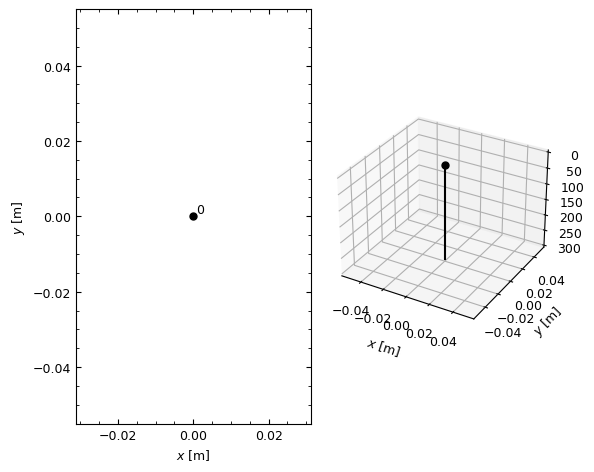

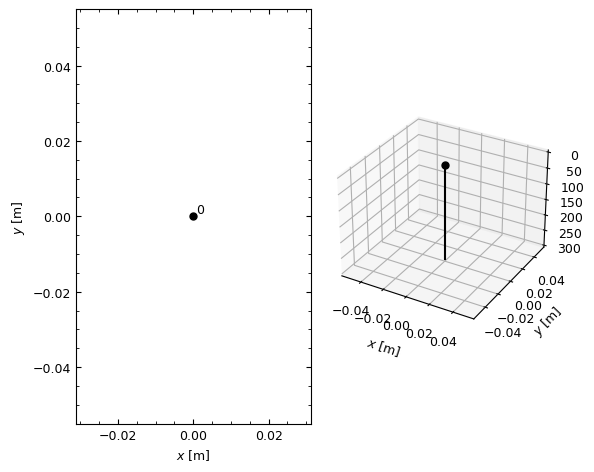

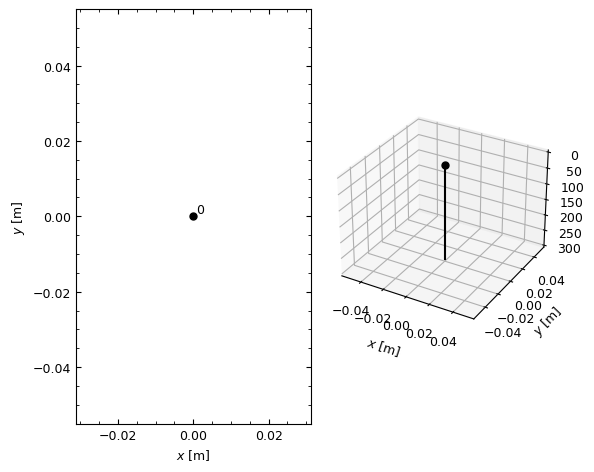

In [141]:
ukjent_param = 'Brønndybde'  # Eller 'COP' eller 'Brønntemp'

antall_aar = 25
grunnlast = np.hstack(antall_aar*[grunnlast])
utetemp = np.hstack(antall_aar*[utetemp])

startCOP = np.array([startCOP]*8760*antall_aar)
COP = startCOP
bronndybde = 50

ellast = grunnlast/COP*virkgrad
bronnlast = grunnlast-ellast

if ukjent_param == 'Validering Brønndybde':
    for k in range(0,10):
        [nybronntemp, t_inn] = kjor_pygf(bronnlast,bronndybde,antall_aar)

        print(nybronntemp)

        if np.min(nybronntemp) <= 0:
            bronndybde = bronndybde+0.25*bronndybde
        elif np.min(nybronntemp) >= 2:
            bronndybde = bronndybde-0.5*bronndybde
        else:
            break

    print('Antall iterasjoner:',k+1)
    print('Nødvendig brønndybde:',bronndybde)
    print('Minste brønntemperatur:',np.min(nybronntemp))
    print(COP)

    bronntemp = nybronntemp
    dybde_GHE = GHE_tool_bronndybde(bronnlast,bronndybde)



elif ukjent_param == 'Brønndybde':
    #dybde_GHE = GHE_tool_bronndybde(bronnlast,bronndybde)
    #dybde_GHE = 108
    

    for k in range(0,10):
        dybde_GHE = GHE_tool_bronndybde(bronnlast,bronndybde)
        [T_ut_her,T_inn] = kjor_pygf(bronnlast,dybde_GHE,antall_aar)
        print('Brønntemp ut fra pygf:')
        print(T_ut_her)
        print('Minste Bronntemp:',np.min(T_ut_her))
        #[COP_35,COP_45,COP_faktisk] = finn_ny_COP(T_ut_her)
        nyCOP = finn_ny_COP_konst_turtemp(T_ut_her)
        print('Ny COP basert på brønntemp fra pygf:')
        print(nyCOP)
        
        if np.mean(np.abs(nyCOP-COP))<0.001:  #Stopper dersom gjennomsnittlig endring i COP-verdi fra forrige iterasjon er mindre enn 0.001
            break
        COP = nyCOP
        ellast = grunnlast/COP*virkgrad
        
        #if np.mean((np.abs(bronnlast - (grunnlast-ellast)))) <= 0.01:
        #    break
        #else:
        bronnlast = grunnlast-ellast

    print('---------------------------------------------')
    print('Brønndybde:',dybde_GHE,'m')
    print('Minste Brønntemp:',np.min(T_ut_her))
    print('Gjennomsnittlig COP:',np.mean(COP))
    print('Minste COP-verdi:',np.min(COP))
    print('Brønnlast gitt denne COP:')
    print(bronnlast)
    


In [142]:
print(np.sum(bronnlast))
print(np.sum(varmelast)/80)
dybde_GHE = GHE_tool_bronndybde(bronnlast,bronndybde)
print(np.mean(COP))


471182.23790290416
329.59882625
Nødvendig brønndybde (GHE-tool): 134.65208650866907 m.
4.036871641615368


In [143]:
plt.plot(t_inn)
plt.plot(nybronntemp)
plt.title(('Brønntemperaturen gjennom', antall_aar, 'år'), fontsize = 20)
plt.xlabel('Timer')
plt.ylabel("Temperatur (degC)")
plt.legend(['Returtemperatur til brønn','Brønntemperatur'])
plt.show()

NameError: name 't_inn' is not defined

In [ ]:
plt.plot(bronntemp,cop35,'.')
plt.plot(bronntemp,cop45,'.')
plt.plot(bronntemp[-8760:],COP[-8760:],'.')

plt.title('COP som funksjon av brønntemp (Utsnitt av lineær regresjon fra datablad)')
plt.xlabel('Brønntemperatur (degC)')
plt.ylabel('COP')
plt.legend(['Turtemperatur 35 degC', 'Turtemperatur 45 degC', 'Også avhengig av utetemperatur'])
plt.show()

NameError: name 'cop35' is not defined

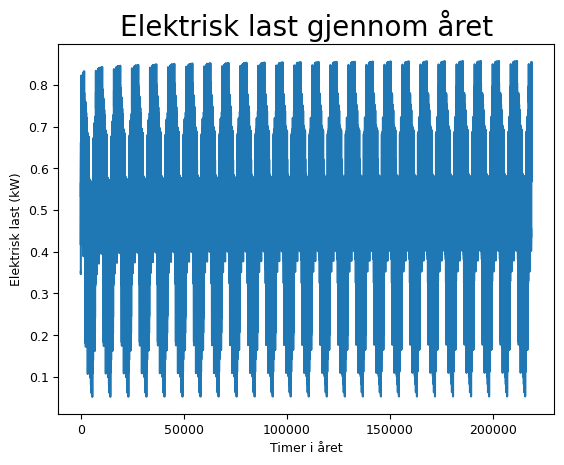

In [ ]:
plt.plot(ellast)
plt.title('Elektrisk last gjennom året', fontsize = 20)
plt.xlabel('Timer i året')
plt.ylabel('Elektrisk last (kW)')
plt.show()

Plotter de tre effekttypene gjennom året. (Setter spisslasten i timer med 0 spisslast til NaN)

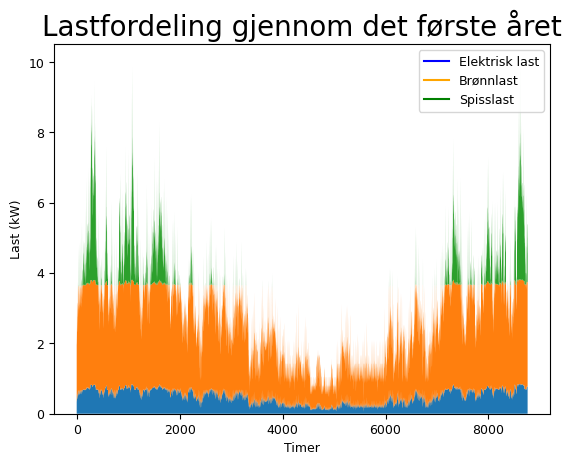

In [ ]:
#timer = np.hstack(antall_aar*[timer])
ellast_forsteaar = ellast[0:8760]
bronnlast_forsteaar = bronnlast[0:8760]
grunnlast_forsteaar = grunnlast[0:8760]

plt.plot([], [], color='blue', label ='Elektrisk last')
plt.plot([], [], color='orange', label ='Brønnlast')
plt.plot([], [], color='green', label ='Spisslast')

plt.stackplot(timer,ellast_forsteaar,bronnlast_forsteaar,spisslast)
plt.xlabel('Timer')
plt.ylabel('Last (kW)')
plt.title('Lastfordeling gjennom det første året', fontsize = 20)
plt.legend()
plt.show()

Sorterer effekttypene i synkende rekkefølge.

In [ ]:
grunnlast_sort=np.sort(grunnlast_forsteaar)[::-1]
ellast_sort=np.sort(ellast_forsteaar)[::-1]
bronnlast_sort = np.sort(bronnlast_forsteaar)[::-1]
spisslast_sort=np.sort(spisslast)[::-1]

Plotter varighetskurvene

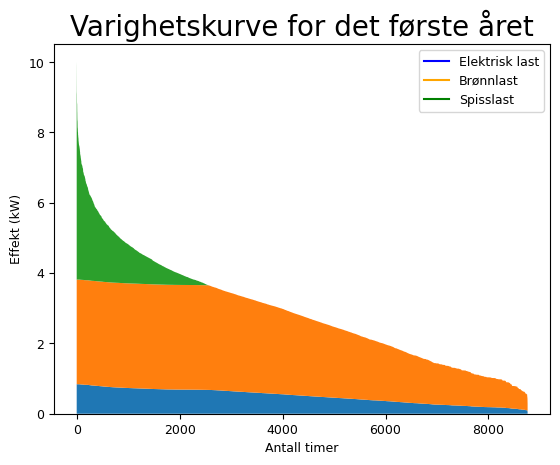

In [ ]:

plt.plot([], [], color='blue', label ='Elektrisk last')
plt.plot([], [], color='orange', label ='Brønnlast')
plt.plot([], [], color='green', label ='Spisslast')
plt.stackplot(timer,ellast_sort,bronnlast_sort,spisslast_sort)

plt.xlabel('Antall timer')
plt.ylabel('Effekt (kW)')
plt.title('Varighetskurve for det første året', fontsize = 20)
plt.legend()
plt.show()

Skriver ut oppsummering av nyttige resultater

In [ ]:
tot_grunnlast=np.sum(grunnlast_forsteaar)
tot_bronnlast = np.sum(bronnlast_forsteaar)
tot_ellast=np.nansum(ellast_forsteaar)
tot_spisslast=np.sum(spisslast)
fakt_dekgrad=tot_grunnlast/(tot_grunnlast+tot_spisslast)*100 #prosent

print("Med ønsket dekningsgrad på",dekgrad*100,"%, blir:")
print("Kapasitet på grunnlast:",round(kap,3),"kW")
print("Antall timer med spisslast:",len(spisslast_sort))
print("Elektrisk energiforbruk det første året:",round(tot_ellast,1),"kWh")
print("Energimengde hentet ut av brønnen det første året:",round(tot_bronnlast,1),"kWh")
print("Energiforbruk grunnlast det første året:",round(tot_grunnlast,1),"kWh")
print("Energiforbruk spisslast det første året:",round(tot_spisslast,1),"kWh")
print("Faktisk dekningsgrad:",round(fakt_dekgrad,2),"%")

Med ønsket dekningsgrad på 90.0 %, blir:
Kapasitet på grunnlast: 3.798 kW
Antall timer med spisslast: 8760
Elektrisk energiforbruk det første året: 4316.9 kWh
Energimengde hentet ut av brønnen det første året: 18457.0 kWh
Energiforbruk grunnlast det første året: 23548.5 kWh
Energiforbruk spisslast det første året: 2819.4 kWh
Faktisk dekningsgrad: 89.31 %


In [ ]:
# Diverse datablader for grunnvarmepumper:
# http://www.mitsubishitech.co.uk/Data/Ecodan/Ground/Monoblock/2015/CRHV-P600YA-HPB/CRHV-P600YA-HPB_Databook.pdf